<a href="https://colab.research.google.com/github/jitbnerejee4/jit/blob/fastai/m5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb
%reload_ext autoreload
%autoreload 2
from fastai.tabular import *
from fastai.basics import *

In [0]:
path = Path('/content')

In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

In [4]:
!kaggle competitions download -c m5-forecasting-accuracy

 58% 9.00M/15.5M [00:00<00:00, 19.7MB/s]
100% 15.5M/15.5M [00:00<00:00, 31.7MB/s]
 35% 5.00M/14.2M [00:00<00:00, 13.8MB/s]
100% 14.2M/14.2M [00:00<00:00, 32.1MB/s]
  0% 0.00/101k [00:00<?, ?B/s]
100% 101k/101k [00:00<00:00, 90.4MB/s]
  0% 0.00/163k [00:00<?, ?B/s]
100% 163k/163k [00:00<00:00, 145MB/s]


In [5]:
!unzip 'sell_prices.csv.zip'
!unzip 'sample_submission.csv.zip'
!unzip 'sales_train_validation.csv.zip'

Archive:  sell_prices.csv.zip
  inflating: sell_prices.csv         
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  sales_train_validation.csv.zip
  inflating: sales_train_validation.csv  


In [6]:
path.ls()

[PosixPath('/content/.config'),
 PosixPath('/content/sales_train_validation.csv'),
 PosixPath('/content/sales_train_validation.csv.zip'),
 PosixPath('/content/calendar.csv'),
 PosixPath('/content/sample_submission.csv'),
 PosixPath('/content/sell_prices.csv'),
 PosixPath('/content/sell_prices.csv.zip'),
 PosixPath('/content/sample_submission.csv.zip'),
 PosixPath('/content/sample_data')]

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

In [0]:
pd.options.display.max_columns = 50

In [6]:
h = 28 
max_lags = 57
tr_last = 1913
fday = datetime(2016,4, 25) 
fday

datetime.datetime(2016, 4, 25, 0, 0)

In [0]:
def create_dt(is_train = True, nrows = None, first_day = 1200):
    prices = pd.read_csv(path/"sell_prices.csv", dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices[col] = prices[col].cat.codes.astype("int16")
            prices[col] -= prices[col].min()
            
    cal = pd.read_csv(path/"calendar.csv", dtype = CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()
    
    start_day = max(1 if is_train  else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv(path/"sales_train_validation.csv", 
                     nrows = nrows, usecols = catcols + numcols, dtype = dtype)
    
    for col in catcols:
        if col != "id":
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()
    
    if not is_train:
        for day in range(tr_last+1, tr_last+ 28 +1):
            dt[f"d_{day}"] = np.nan
    
    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    
    dt = dt.merge(cal, on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    
    return dt

In [0]:
def create_fea(dt):
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)

    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())

    
    
    date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")

In [0]:
FIRST_DAY = 350 # If you want to load all the data set it to '1' -->  Great  memory overflow  risk !

In [10]:
%%time

df = create_dt(is_train=True, first_day= FIRST_DAY)
df.shape

CPU times: user 27.9 s, sys: 2.76 s, total: 30.7 s
Wall time: 32.6 s


In [11]:
df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_350,0.0,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,3.97
1,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,d_350,2.0,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,4.34
2,HOBBIES_1_005_CA_1_validation,4,0,0,0,0,d_350,0.0,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,2.48
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_350,0.0,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,0.50
4,HOBBIES_1_009_CA_1_validation,8,0,0,0,0,d_350,2.0,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,1.77


In [12]:
df.shape

(40718219, 22)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40718219 entries, 0 to 40718218
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int16         
 3   store_id      int16         
 4   cat_id        int16         
 5   state_id      int16         
 6   d             object        
 7   sales         float32       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int16         
 11  wday          int16         
 12  month         int16         
 13  year          int16         
 14  event_name_1  int16         
 15  event_type_1  int16         
 16  event_name_2  int16         
 17  event_type_2  int16         
 18  snap_CA       float32       
 19  snap_TX       float32       
 20  snap_WI       float32       
 21  sell_price    float32       
dtypes: datetime64[ns](1), float32(5), int16(14), object(2)
memory us

In [14]:
create_fea(df)
df.shape

(40718219, 31)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40718219 entries, 0 to 40718218
Data columns (total 31 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int16         
 3   store_id      int16         
 4   cat_id        int16         
 5   state_id      int16         
 6   d             object        
 7   sales         float32       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int16         
 11  wday          int16         
 12  month         int16         
 13  year          int16         
 14  event_name_1  int16         
 15  event_type_1  int16         
 16  event_name_2  int16         
 17  event_type_2  int16         
 18  snap_CA       float32       
 19  snap_TX       float32       
 20  snap_WI       float32       
 21  sell_price    float32       
 22  lag_7         float32       
 23  lag_28        float32       
 

In [16]:
df.tail()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
40718214,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.98,0.0,1.0,1.000000,0.714286,0.928571,1.250000,16,2,24
40718215,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,0.0,2.0,0.857143,1.142857,1.035714,1.107143,16,2,23
40718216,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1913,3.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,1.0,4.0,0.714286,1.571429,1.035714,1.250000,16,2,24
40718217,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.00,0.0,0.0,0.000000,2.285714,1.821429,1.785714,16,2,23
40718218,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.00,0.0,5.0,0.000000,2.428571,1.678571,1.964286,16,2,24


In [17]:
df.dropna(inplace = True)
df.shape

(39041269, 31)

In [0]:
df = df.assign(d = df.d.str[2:].astype(int))

In [19]:
df.tail()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
40718214,FOODS_3_825_WI_3_validation,3046,6,9,2,2,1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.98,0.0,1.0,1.000000,0.714286,0.928571,1.250000,16,2,24
40718215,FOODS_3_826_WI_3_validation,3047,6,9,2,2,1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,0.0,2.0,0.857143,1.142857,1.035714,1.107143,16,2,23
40718216,FOODS_3_826_WI_3_validation,3047,6,9,2,2,1913,3.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,1.0,4.0,0.714286,1.571429,1.035714,1.250000,16,2,24
40718217,FOODS_3_827_WI_3_validation,3048,6,9,2,2,1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.00,0.0,0.0,0.000000,2.285714,1.821429,1.785714,16,2,23
40718218,FOODS_3_827_WI_3_validation,3048,6,9,2,2,1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.00,0.0,5.0,0.000000,2.428571,1.678571,1.964286,16,2,24


In [0]:
useless_cols = ["date", "wm_yr_wk", "weekday"]
train_cols = df.columns[~df.columns.isin(useless_cols)]
dep_var= 'sales'
cat_vars = ['item_id','dept_id', 'store_id', 'cat_id', 'state_id', 'event_name_1', 'event_name_2',
             'event_type_1', 'event_type_2']
cont_vars = ['sales', 'wday', 'month', 'year','snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'lag_7', 'lag_28', 'rmean_7_7',
             'rmean_28_7', 'rmean_7_28', 'rmean_28_28', 'week', 'quarter', 'mday']

In [0]:
procs=[FillMissing, Categorify, Normalize]

In [0]:
train_ds = df[df.d < 1886]

In [40]:
train_ds.drop(useless_cols, axis=1)

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
869062,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,405,0.0,6,3,2012,24,3,0,0,1.0,0.0,1.0,3.97,0.0,0.0,0.000000,0.142857,0.214286,0.214286,10,1,8
869063,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,406,0.0,7,3,2012,0,0,0,0,1.0,1.0,1.0,3.97,0.0,1.0,0.000000,0.142857,0.178571,0.250000,10,1,9
869069,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,405,1.0,6,3,2012,24,3,0,0,1.0,0.0,1.0,4.34,3.0,2.0,1.857143,1.142857,1.392857,1.678571,10,1,8
869070,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,406,2.0,7,3,2012,0,0,0,0,1.0,1.0,1.0,4.34,1.0,0.0,2.000000,1.000000,1.392857,1.607143,10,1,9
869076,HOBBIES_1_005_CA_1_validation,4,0,0,0,0,405,0.0,6,3,2012,24,3,0,0,1.0,0.0,1.0,2.98,0.0,0.0,0.000000,1.857143,0.750000,0.642857,10,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40016929,FOODS_3_825_WI_3_validation,3046,6,9,2,2,1885,1.0,2,3,2016,5,1,0,0,0.0,0.0,0.0,3.98,0.0,0.0,1.000000,0.428571,1.178571,0.642857,12,1,27
40016935,FOODS_3_826_WI_3_validation,3047,6,9,2,2,1884,2.0,1,3,2016,0,0,0,0,0.0,0.0,0.0,1.28,1.0,0.0,1.428571,0.000000,0.821429,1.000000,12,1,26
40016936,FOODS_3_826_WI_3_validation,3047,6,9,2,2,1885,4.0,2,3,2016,5,1,0,0,0.0,0.0,0.0,1.28,1.0,0.0,1.142857,0.000000,0.857143,0.892857,12,1,27
40016942,FOODS_3_827_WI_3_validation,3048,6,9,2,2,1884,0.0,1,3,2016,0,0,0,0,0.0,0.0,0.0,1.00,1.0,4.0,2.142857,1.571429,1.607143,1.607143,12,1,26


In [41]:
test_ds = df[df.d >= 1886]
test_ds = test_ds.assign(id=test_ds.id + "_" + np.where(test_ds.d <= 1913, "validation", "evaluation"),
                   F="F" + (test_ds.d - 1885 - 28 * (test_ds.d > 1913)).astype("str"))
test_ds.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday,F
39803521,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1886,1.0,2016-03-28,11609,1,3,3,2016,0,0,0,0,0.0,0.0,0.0,8.26,1.0,0.0,1.571429,1.142857,1.035714,1.000000,13,1,28,F1
39803522,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1887,0.0,2016-03-29,11609,5,4,3,2016,0,0,0,0,0.0,0.0,0.0,8.26,2.0,2.0,1.714286,1.428571,1.107143,1.035714,13,1,29,F2
39803523,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1888,0.0,2016-03-30,11609,6,5,3,2016,0,0,0,0,0.0,0.0,0.0,8.26,2.0,0.0,1.857143,1.285714,1.142857,1.000000,13,1,30,F3
39803524,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1889,0.0,2016-03-31,11609,4,6,3,2016,0,0,0,0,0.0,0.0,0.0,8.26,0.0,1.0,1.714286,1.428571,1.142857,1.000000,13,1,31,F4
39803525,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1890,0.0,2016-04-01,11609,0,7,4,2016,0,0,0,0,1.0,1.0,0.0,8.26,1.0,1.0,1.428571,1.428571,1.142857,1.035714,13,2,1,F5


In [42]:
test_ds.drop(useless_cols, axis=1)

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday,F
39803521,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1886,1.0,3,3,2016,0,0,0,0,0.0,0.0,0.0,8.26,1.0,0.0,1.571429,1.142857,1.035714,1.000000,13,1,28,F1
39803522,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1887,0.0,4,3,2016,0,0,0,0,0.0,0.0,0.0,8.26,2.0,2.0,1.714286,1.428571,1.107143,1.035714,13,1,29,F2
39803523,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1888,0.0,5,3,2016,0,0,0,0,0.0,0.0,0.0,8.26,2.0,0.0,1.857143,1.285714,1.142857,1.000000,13,1,30,F3
39803524,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1889,0.0,6,3,2016,0,0,0,0,0.0,0.0,0.0,8.26,0.0,1.0,1.714286,1.428571,1.142857,1.000000,13,1,31,F4
39803525,HOBBIES_1_001_CA_1_validation_validation,0,0,0,0,0,1890,0.0,7,4,2016,0,0,0,0,1.0,1.0,0.0,8.26,1.0,1.0,1.428571,1.428571,1.142857,1.035714,13,2,1,F5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40718214,FOODS_3_825_WI_3_validation_validation,3046,6,9,2,2,1913,0.0,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.98,0.0,1.0,1.000000,0.714286,0.928571,1.250000,16,2,24,F28
40718215,FOODS_3_826_WI_3_validation_validation,3047,6,9,2,2,1912,1.0,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,0.0,2.0,0.857143,1.142857,1.035714,1.107143,16,2,23,F27
40718216,FOODS_3_826_WI_3_validation_validation,3047,6,9,2,2,1913,3.0,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,1.0,4.0,0.714286,1.571429,1.035714,1.250000,16,2,24,F28
40718217,FOODS_3_827_WI_3_validation_validation,3048,6,9,2,2,1912,0.0,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.00,0.0,0.0,0.000000,2.285714,1.821429,1.785714,16,2,23,F27


In [0]:
test_ds = test_ds.sample(100000)

In [33]:
test_ds.shape

(100000, 32)

In [41]:
x_train.head()

,item_id,dept_id,store_id,cat_id,state_id,sales,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
20752382,240,0,0,0,0,2.0,1,6,2014,0,0,0,0,0.0,0.0,0.0,0.94,4.0,2.0,2.285714,2.142857,2.035714,1.821429,26,2,28
20671541,143,0,6,0,1,2.0,3,6,2014,0,0,0,0,0.0,0.0,0.0,4.88,2.0,3.0,1.285714,2.142857,1.607143,1.678571,26,2,23
33581245,553,1,8,0,2,0.0,6,9,2015,0,0,0,0,1.0,1.0,1.0,0.97,0.0,0.0,0.142857,0.142857,0.214286,0.178571,36,3,3
38258369,1756,5,7,2,2,1.0,3,2,2016,0,0,0,0,1.0,1.0,0.0,6.47,0.0,0.0,0.142857,0.285714,0.214286,0.428571,5,1,1
32224700,1165,3,4,1,1,1.0,5,7,2015,0,0,0,0,0.0,0.0,0.0,1.96,0.0,0.0,0.142857,0.285714,0.178571,0.107143,30,3,22


In [0]:
train_ds = train_ds.sample(10000000)

In [44]:
train_ds.shape

(10000000, 31)

In [46]:
x_test.head()

,item_id,dept_id,store_id,cat_id,state_id,sales,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
28396893,661,2,3,1,0,0.0,1,3,2015,0,0,0,0,0.0,0.0,1.0,7.97,0.0,2.0,0.142857,0.571429,0.428571,0.535714,11,1,14
30611996,1287,3,8,1,2,0.0,3,5,2015,15,2,0,0,0.0,0.0,0.0,8.97,0.0,0.0,0.000000,0.000000,0.035714,0.000000,22,2,25
16870789,81,0,9,0,2,0.0,6,2,2014,0,0,0,0,1.0,1.0,1.0,4.38,0.0,0.0,0.000000,0.428571,0.321429,0.500000,6,1,6
40089324,1192,3,3,1,0,0.0,3,4,2016,0,0,0,0,1.0,0.0,0.0,0.98,0.0,0.0,0.285714,0.571429,0.285714,0.464286,14,2,4
8816343,411,0,8,0,2,1.0,5,3,2013,0,0,0,0,0.0,0.0,0.0,5.74,0.0,1.0,0.428571,0.285714,0.250000,0.178571,12,1,20


In [0]:
x_train['sales']=x_train['sales'].replace(0,x_train['sales'].mean())
x_test['sales']=x_test['sales'].replace(0,x_test['sales'].mean())

In [0]:
del useless_cols, df

In [0]:
data = (TabularList.from_df(train_ds, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                .split_by_rand_pct()
                .label_from_df(cols=dep_var, label_cls=FloatList, log=False)
                .add_test(TabularList.from_df(test_ds, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

In [0]:
max_log_y = np.log(np.max(t['sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [35]:
data

TabularDataBunch;

Train: LabelList (160000 items)
x: TabularList
item_id 1896; dept_id 5; store_id 7; cat_id 2; state_id 2; event_name_1 0; event_name_2 0; event_type_1 0; event_type_2 0; sales 0.6359; wday 0.0022; month -1.2870; year -0.7602; snap_CA 1.4390; snap_TX 1.4332; snap_WI 1.4285; sell_price 1.6156; lag_7 1.0955; lag_28 -0.3204; rmean_7_7 1.2337; rmean_28_7 0.0945; rmean_7_28 0.5984; rmean_28_28 -0.0808; week -1.3437; quarter -1.3169; mday -1.2264; ,item_id 2117; dept_id 5; store_id 8; cat_id 2; state_id 2; event_name_1 0; event_name_2 0; event_type_1 0; event_type_2 0; sales -0.3261; wday -0.9952; month 1.0056; year -0.7602; snap_CA -0.6955; snap_TX 1.4332; snap_WI -0.7002; sell_price 0.8850; lag_7 -0.3228; lag_28 -0.3204; rmean_7_7 -0.3613; rmean_28_7 -0.3660; rmean_7_28 -0.3804; rmean_28_28 -0.3773; week 0.9477; quarter 1.3282; mday -0.3144; ,item_id 1926; dept_id 5; store_id 0; cat_id 2; state_id 0; event_name_1 0; event_name_2 0; event_type_1 0; event_type_2 0; sales 0.

In [0]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        metrics=rmse)

In [52]:
learn.lr_find()

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


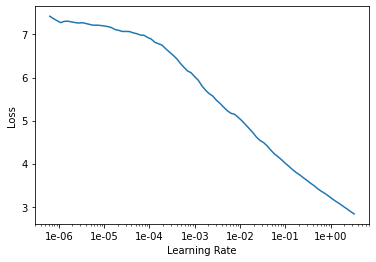

In [54]:
learn.recorder.plot()

In [55]:
learn.fit_one_cycle(1, 1e-4, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.402759,0.220144,0.453325,00:21


In [0]:
learn.save('stage-1')

In [58]:
learn.lr_find()

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


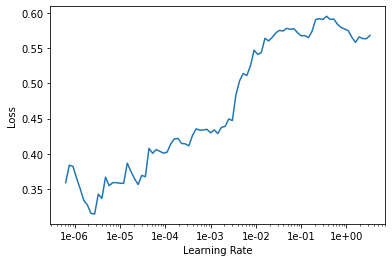

In [59]:
learn.recorder.plot()

In [60]:
learn.load('stage-1')

Learner(data=TabularDataBunch;

Train: LabelList (160000 items)
x: TabularList
item_id 143; dept_id 0; store_id 6; cat_id 0; state_id 1; event_name_1 0; event_name_2 0; event_type_1 0; event_type_2 0; sales -0.0467; wday -0.5006; month -0.1278; year 0.0490; snap_CA -0.6984; snap_TX -0.6951; snap_WI -0.6963; sell_price 0.1323; lag_7 0.1591; lag_28 0.3992; rmean_7_7 -0.0189; rmean_28_7 0.2151; rmean_7_28 0.0722; rmean_28_28 0.0920; week -0.0200; quarter -0.4289; mday 0.8280; ,item_id 1165; dept_id 3; store_id 4; cat_id 1; state_id 1; event_name_1 0; event_name_2 0; event_type_1 0; event_type_2 0; sales -0.3098; wday 0.4989; month 0.1604; year 0.8781; snap_CA -0.6984; snap_TX -0.6951; snap_WI -0.6963; sell_price -0.7162; lag_7 -0.3352; lag_28 -0.3294; rmean_7_7 -0.3325; rmean_28_7 -0.2946; rmean_7_28 -0.3396; rmean_28_28 -0.3593; week 0.2433; quarter 0.4598; mday 0.7139; ,item_id 2770; dept_id 6; store_id 3; cat_id 2; state_id 0; event_name_1 13; event_name_2 0; event_type_1 3; event_type

In [61]:
learn.fit_one_cycle(5, 2e-6, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.350043,0.198290,0.421151,00:21
1,0.360613,0.228046,0.465413,00:21
2,0.284923,0.155338,0.373409,00:21
3,0.323118,0.179099,0.406570,00:21
4,0.282699,0.188315,0.411178,00:21


In [0]:
learn.save('stage-2')

In [63]:
learn.lr_find()

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


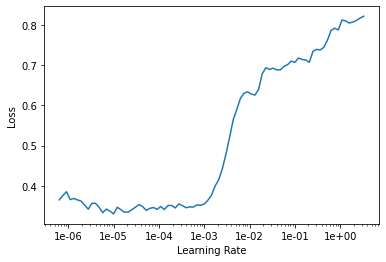

In [65]:
learn.recorder.plot()

In [110]:
preds=learn.get_preds(DatasetType.Test)

In [111]:
preds

[tensor([[0.4725],
         [0.7052],
         [0.5128],
         ...,
         [0.5302],
         [0.6203],
         [0.4267]]), tensor([0, 0, 0,  ..., 0, 0, 0])]

In [0]:
x_test["Sales"]=np.exp(preds[0].data).numpy().T[0]

In [135]:
x_test.drop('sales', axis=1)

,item_id,dept_id,store_id,cat_id,state_id,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday,Sales
28396893,661,2,3,1,0,1,3,2015,0,0,0,0,0.0,0.0,1.0,7.97,0.0,2.0,0.142857,0.571429,0.428571,0.535714,11,1,14,1.603960
30611996,1287,3,8,1,2,3,5,2015,15,2,0,0,0.0,0.0,0.0,8.97,0.0,0.0,0.000000,0.000000,0.035714,0.000000,22,2,25,2.024346
16870789,81,0,9,0,2,6,2,2014,0,0,0,0,1.0,1.0,1.0,4.38,0.0,0.0,0.000000,0.428571,0.321429,0.500000,6,1,6,1.670014
40089324,1192,3,3,1,0,3,4,2016,0,0,0,0,1.0,0.0,0.0,0.98,0.0,0.0,0.285714,0.571429,0.285714,0.464286,14,2,4,1.550832
8816343,411,0,8,0,2,5,3,2013,0,0,0,0,0.0,0.0,0.0,5.74,0.0,1.0,0.428571,0.285714,0.250000,0.178571,12,1,20,1.358687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25991061,2795,6,7,2,2,6,12,2014,2,2,0,0,0.0,0.0,0.0,8.68,0.0,0.0,0.000000,0.000000,0.000000,0.000000,52,4,25,1.703219
36665704,2871,6,2,2,0,6,12,2015,0,0,0,0,0.0,0.0,0.0,1.28,4.0,4.0,2.142857,2.571429,2.571429,2.750000,51,4,17,1.978649
31668149,534,1,8,0,2,3,6,2015,0,0,0,0,0.0,0.0,0.0,2.97,0.0,0.0,0.000000,0.000000,0.000000,0.000000,27,2,29,1.699353
22681587,824,2,6,1,1,6,9,2014,0,0,0,0,1.0,0.0,0.0,4.46,3.0,1.0,1.000000,0.428571,0.857143,1.178571,36,3,4,1.859541


In [0]:
temp=[]
for sale in x_test['Sales']:
  temp.append(sale)

In [153]:
df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
869062,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_405,0.0,2012-03-08,11206,4,6,3,2012,24,3,0,0,1.0,0.0,1.0,3.97,0.0,0.0,0.000000,0.142857,0.214286,0.214286,10,1,8
869063,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_406,0.0,2012-03-09,11206,0,7,3,2012,0,0,0,0,1.0,1.0,1.0,3.97,0.0,1.0,0.000000,0.142857,0.178571,0.250000,10,1,9
869069,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,d_405,1.0,2012-03-08,11206,4,6,3,2012,24,3,0,0,1.0,0.0,1.0,4.34,3.0,2.0,1.857143,1.142857,1.392857,1.678571,10,1,8
869070,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,d_406,2.0,2012-03-09,11206,0,7,3,2012,0,0,0,0,1.0,1.0,1.0,4.34,1.0,0.0,2.000000,1.000000,1.392857,1.607143,10,1,9
869076,HOBBIES_1_005_CA_1_validation,4,0,0,0,0,d_405,0.0,2012-03-08,11206,4,6,3,2012,24,3,0,0,1.0,0.0,1.0,2.98,0.0,0.0,0.000000,1.857143,0.750000,0.642857,10,1,8


In [140]:
len(temp)

10000

In [0]:
ss = pd.read_csv('sample_submission.csv')

In [78]:
ss.shape

(60980, 29)

In [0]:
learn.export('export.pkl')

In [127]:
pred_valid.T

""
id
HOBBIES_1_001_CA_1_validation
HOBBIES_1_002_CA_1_validation
HOBBIES_1_003_CA_1_validation
HOBBIES_1_004_CA_1_validation
HOBBIES_1_005_CA_1_validation
...
FOODS_3_823_WI_3_validation
FOODS_3_824_WI_3_validation
FOODS_3_825_WI_3_validation


In [0]:
eval_df = df[pd.to_datetime(df['date']) >= '2016-04-20']

In [0]:
train_df = df[(pd.to_datetime(df['date']) < '2016-04-20')&(pd.to_datetime(df['date']) >= '2012-03-08')].drop('date', axis=1)

In [0]:
data2 = (TabularList.from_df(x_train, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                .split_by_rand_pct()
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(x_test, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())